# Self-Driving Car Engineer Nanodegree
## Vehicle Detection
---
In this project, I'll write a software pipeline to detect vehicles in a video.

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import random
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
def convert_color(image, color_space = 'RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: converted_image = np.copy(image)      
    return converted_image

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Load Training Data

In [3]:
car_images = sorted(glob.glob('training_images/vehicles/**/*.png'))
noncar_images = sorted(glob.glob('training_images/non-vehicles/**/*.png'))

print(str(len(car_images)) + ' car training data.')
print(str(len(noncar_images)) + ' non-car training data.')

8792 car training data.
8968 non-car training data.


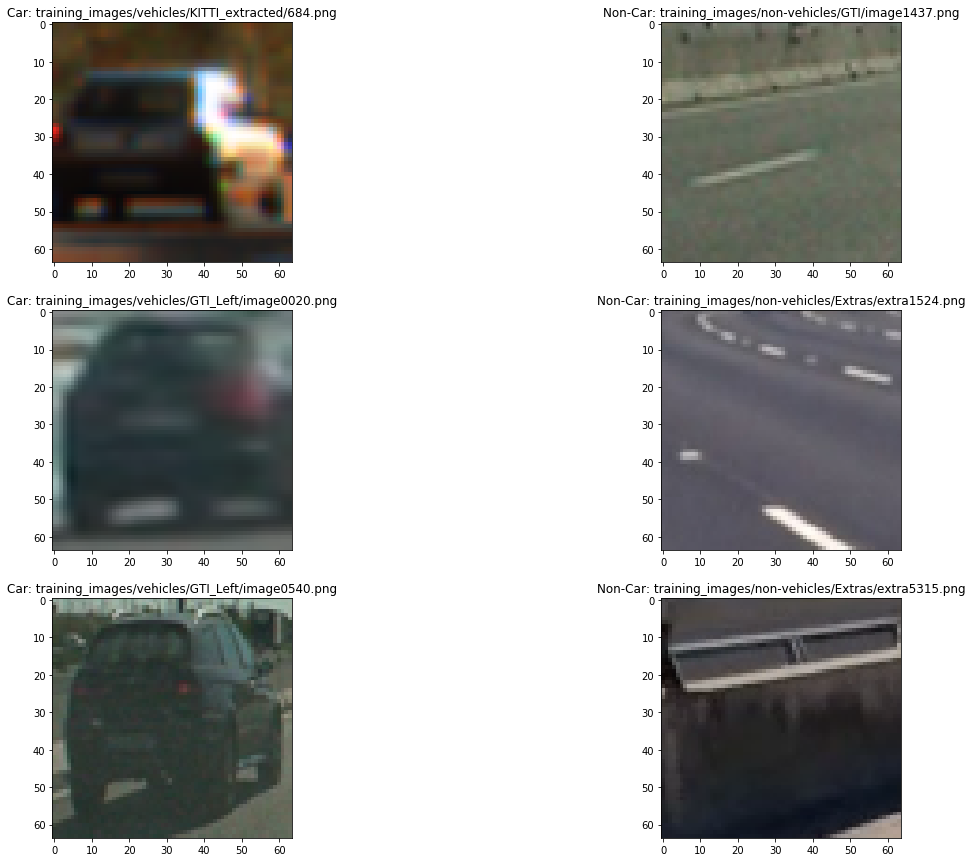

In [4]:
sample_size = 3
sample_car_images = random.sample(car_images, sample_size)
sample_noncar_images = random.sample(noncar_images, sample_size)

fig = plt.figure(figsize = (20, 15))
for i in range(len(sample_car_images)):
    car_image = sample_car_images[i]
    noncar_image = sample_noncar_images[i]
    car_img = mpimg.imread(car_image)
    noncar_img = mpimg.imread(noncar_image)

    ax1 = fig.add_subplot(3,2,(i*2)+1)
    ax1.set_title('Car: ' + car_image)
    ax1.imshow(car_img)
    ax2 = fig.add_subplot(3,2,(i*2)+2)
    ax2.set_title('Non-Car: ' + noncar_image)
    ax2.imshow(noncar_img)

## HOG

### Car Samples:

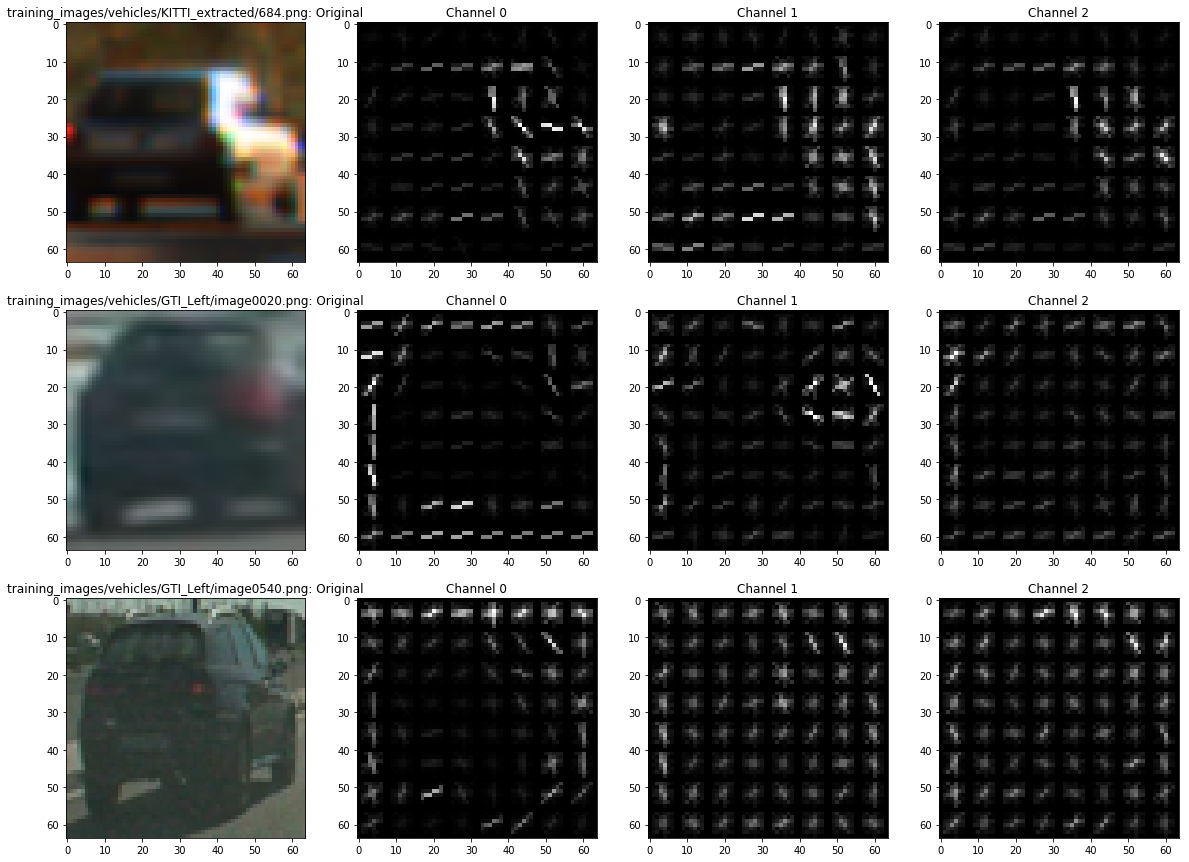

In [5]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

fig = plt.figure(figsize = (20, 15))

for i in range(len(sample_car_images)):
    car_image = sample_car_images[i]
    image = mpimg.imread(car_image)

    ax1 = fig.add_subplot(3,4,(i*4)+1)
    ax1.set_title(car_image + ': Original')
    ax1.imshow(image)

    converted = convert_color(image, color_space=color_space)
    for j in range(3):
        features, hog_image = get_hog_features(converted[:,:,j], orient=orient, 
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
            vis=True, feature_vec=False)

        ax2 = fig.add_subplot(3,4,(i*4)+j+2)
        ax2.set_title('Channel ' + str(j))
        ax2.imshow(hog_image, cmap='gray')

### Non-Car Samples:

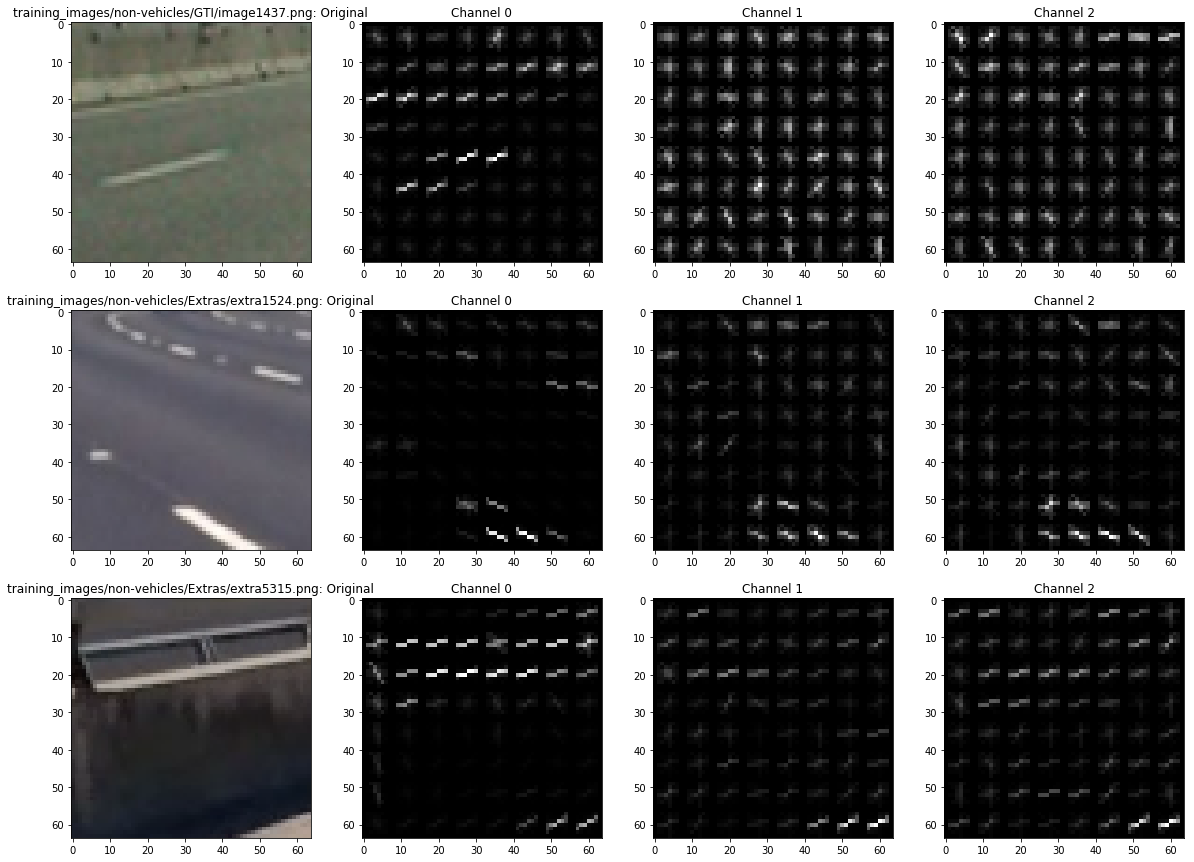

In [6]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

fig = plt.figure(figsize = (20, 15))

for i in range(len(sample_noncar_images)):
    noncar_image = sample_noncar_images[i]
    image = mpimg.imread(noncar_image)

    ax1 = fig.add_subplot(3,4,(i*4)+1)
    ax1.set_title(noncar_image + ': Original')
    ax1.imshow(image)

    converted = convert_color(image, color_space=color_space)
    for j in range(3):
        features, hog_image = get_hog_features(converted[:,:,j], orient=orient, 
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
            vis=True, feature_vec=False)

        ax2 = fig.add_subplot(3,4,(i*4)+j+2)
        ax2.set_title('Channel ' + str(j))
        ax2.imshow(hog_image, cmap='gray')

## Training Classifier

In [7]:
# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = mpimg.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors

In [8]:
# Define parameters for feature extraction
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Car samples: ', len(car_features))
noncar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Non-Car samples: ', len(noncar_features))
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

svc = LinearSVC() # Use a linear SVC 
svc.fit(X_train, y_train) # Train the classifier
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

Car samples:  8792
Non-Car samples:  8968
Test Accuracy of SVC =  0.9837


## Test Images

6 test images.


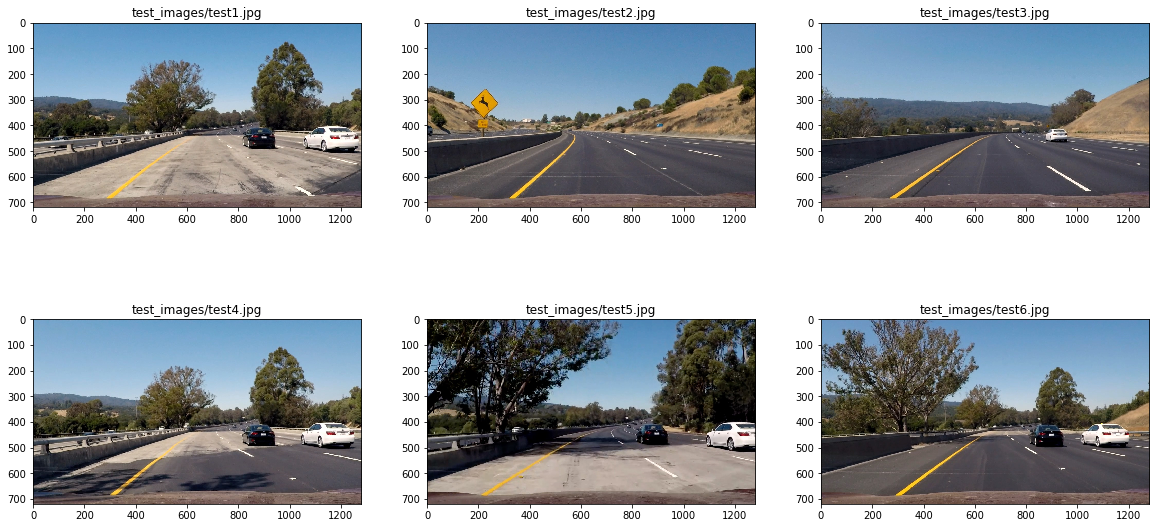

In [9]:
test_images = sorted(glob.glob('test_images/*.jpg'))

print(str(len(test_images)) + ' test images.')

fig = plt.figure(figsize = (20, 10))
for i in range(len(test_images)):
    test_image = test_images[i]
    image = mpimg.imread(test_image)

    ax = fig.add_subplot(2,3,(i)+1)
    ax.set_title(test_image)
    ax.imshow(image)

In [10]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [12]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

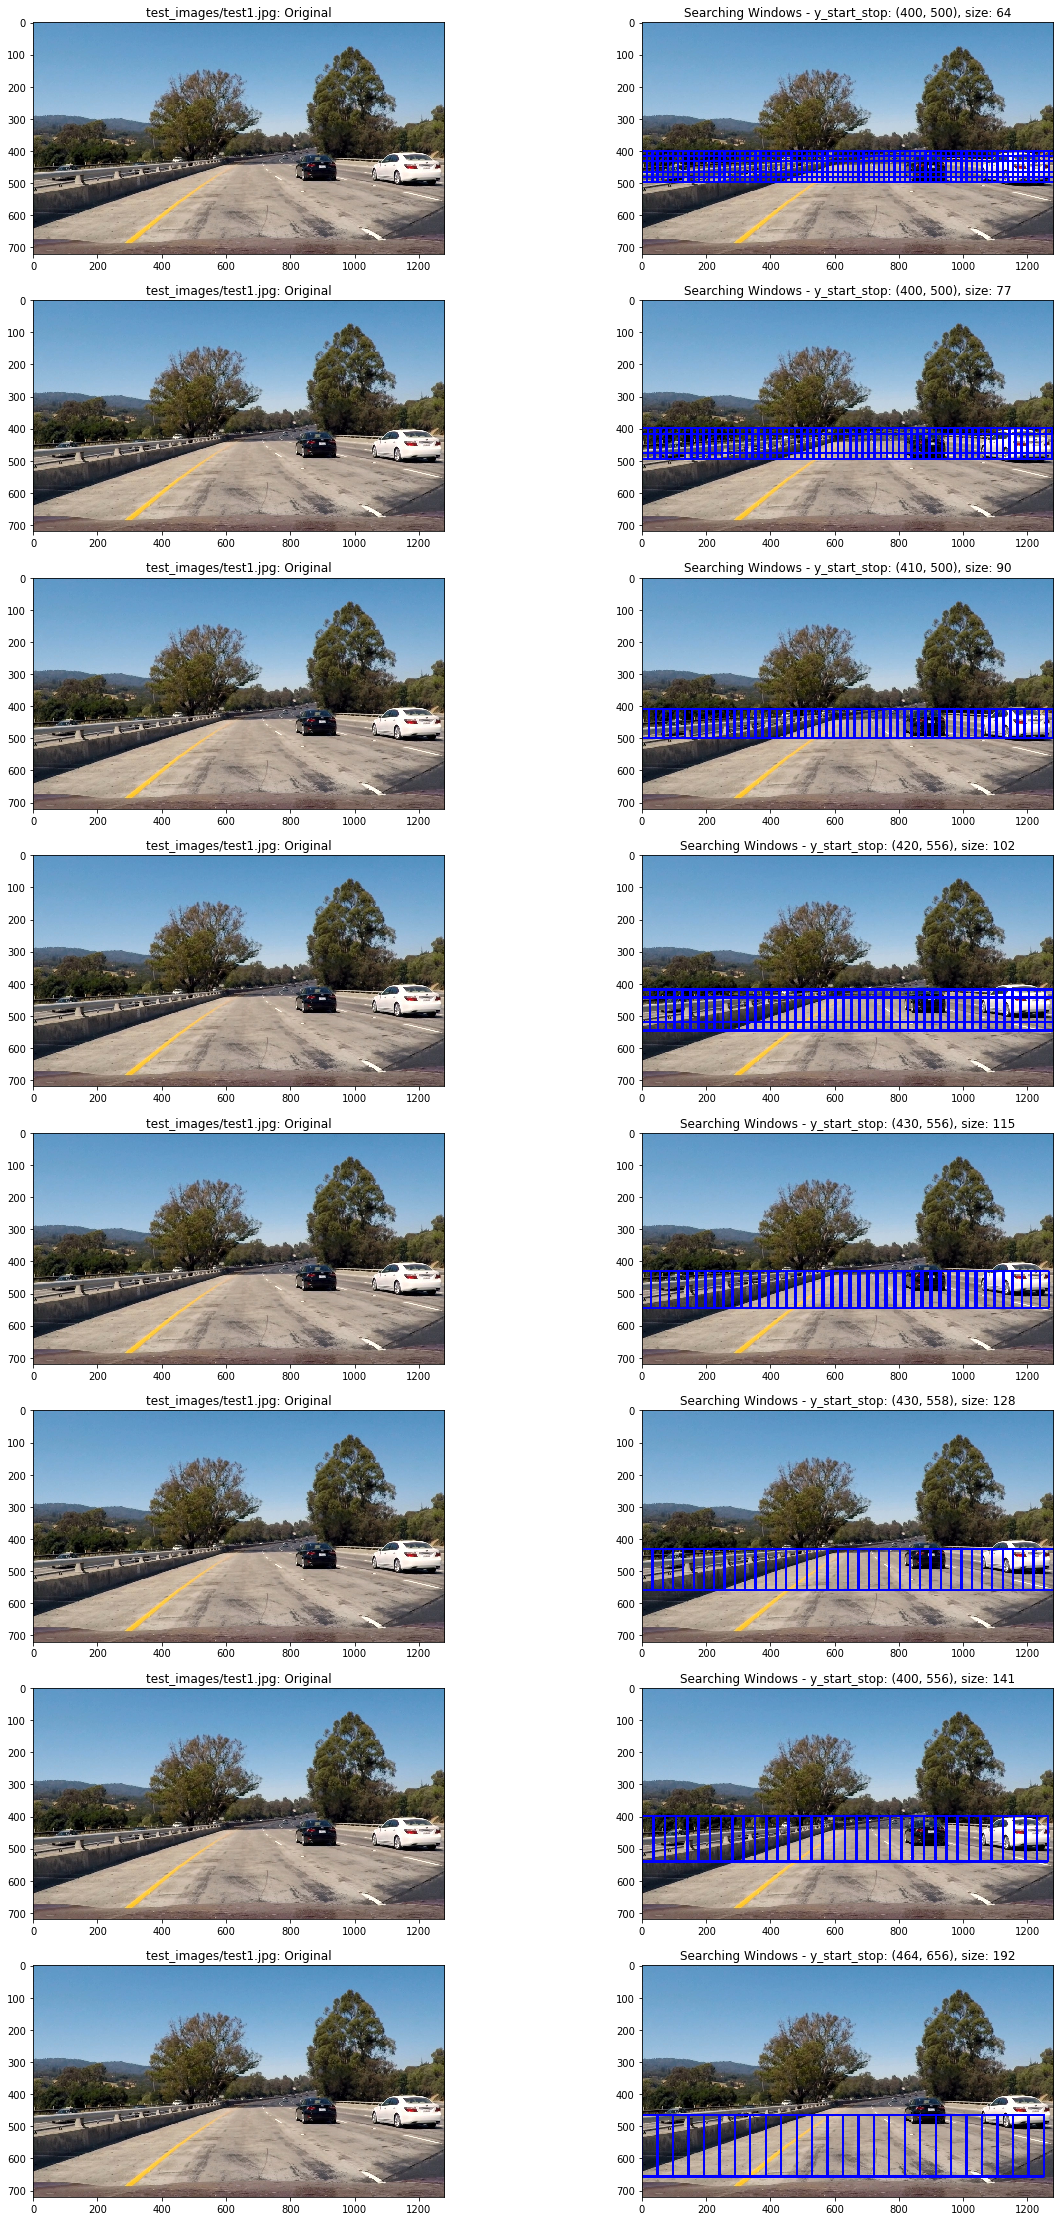

In [13]:
fig = plt.figure(figsize = (20, 40))

base_size = 64
xy_overlap = (0.75, 0.75)
windows_list = []
windows_list.append([400, 500, 1.0])
windows_list.append([400, 500, 1.2])
windows_list.append([410, 500, 1.4])
windows_list.append([420, 556, 1.6])
windows_list.append([430, 556, 1.8])
windows_list.append([430, 558, 2.0])
windows_list.append([400, 556, 2.2])
windows_list.append([464, 656, 3.0])

windows = []
for i in range(len(windows_list)):
    y_start_stop = (windows_list[i][0], windows_list[i][1])
    size = int(round(base_size * windows_list[i][2]))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(size,size), xy_overlap=xy_overlap)

for i in range(len(windows_list)):
    y_start_stop = (windows_list[i][0], windows_list[i][1])
    size = int(round(base_size * windows_list[i][2]))
    temp_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(size,size), xy_overlap=xy_overlap)

    test_image = test_images[0]
    image = mpimg.imread(test_image)
    draw_image = np.copy(image)

    draw_image = draw_boxes(draw_image, temp_windows, color=(0, 0, 255), thick=6)                   

    ax1 = fig.add_subplot(8,2,(i*2)+1)
    ax1.set_title(test_image + ': Original')
    ax1.imshow(image)
    ax2 = fig.add_subplot(8,2,(i*2)+2)
    ax2.set_title('Searching Windows - y_start_stop: ' + str(y_start_stop) + ', size: ' + str(size))
    ax2.imshow(draw_image)

In [14]:
def find_cars(image):
    hot_windows = (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))
    
    return hot_windows

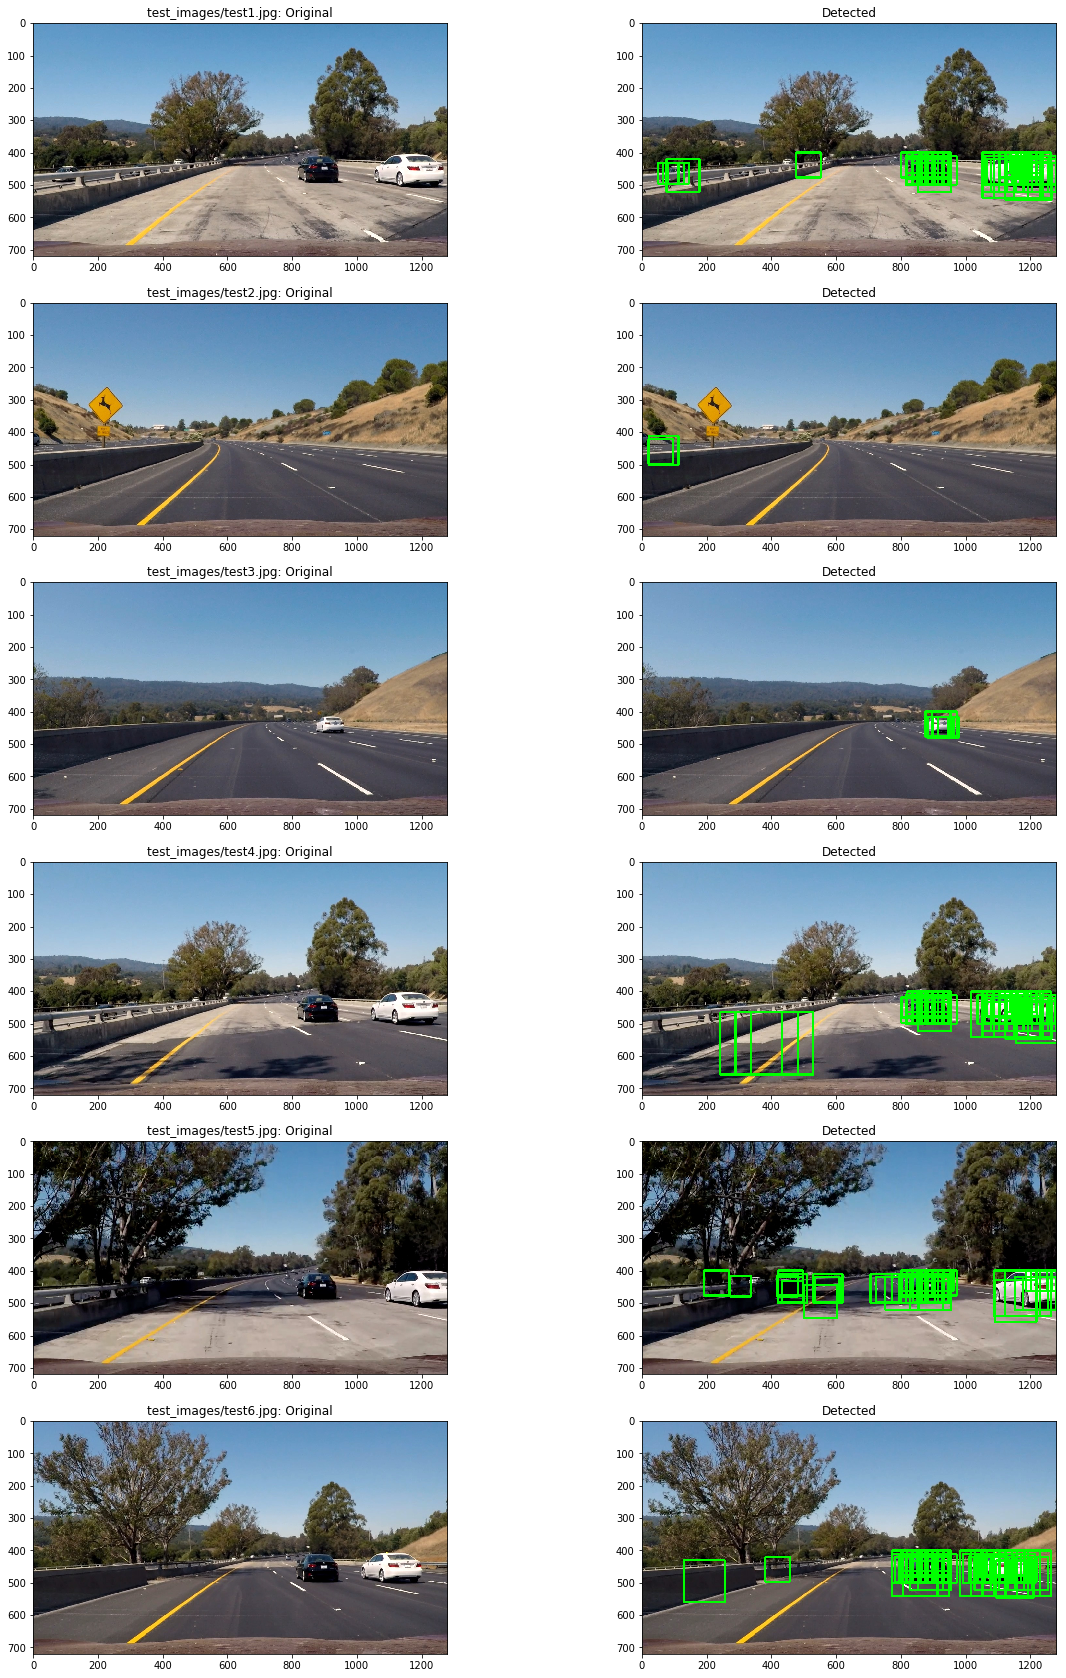

In [15]:
fig = plt.figure(figsize = (20, 30))

for i in range(len(test_images)):
    test_image = test_images[i]
    image = mpimg.imread(test_image)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    hot_windows = find_cars(image)           
    draw_image = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                   

    ax1 = fig.add_subplot(6,2,(i*2)+1)
    ax1.set_title(test_image + ': Original')
    ax1.imshow(image)
    ax2 = fig.add_subplot(6,2,(i*2)+2)
    ax2.set_title('Detected')
    ax2.imshow(draw_image)

In [16]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_heatmap(img, hot_windows, threshold=1):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

def draw_labels(image, heatmap):
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

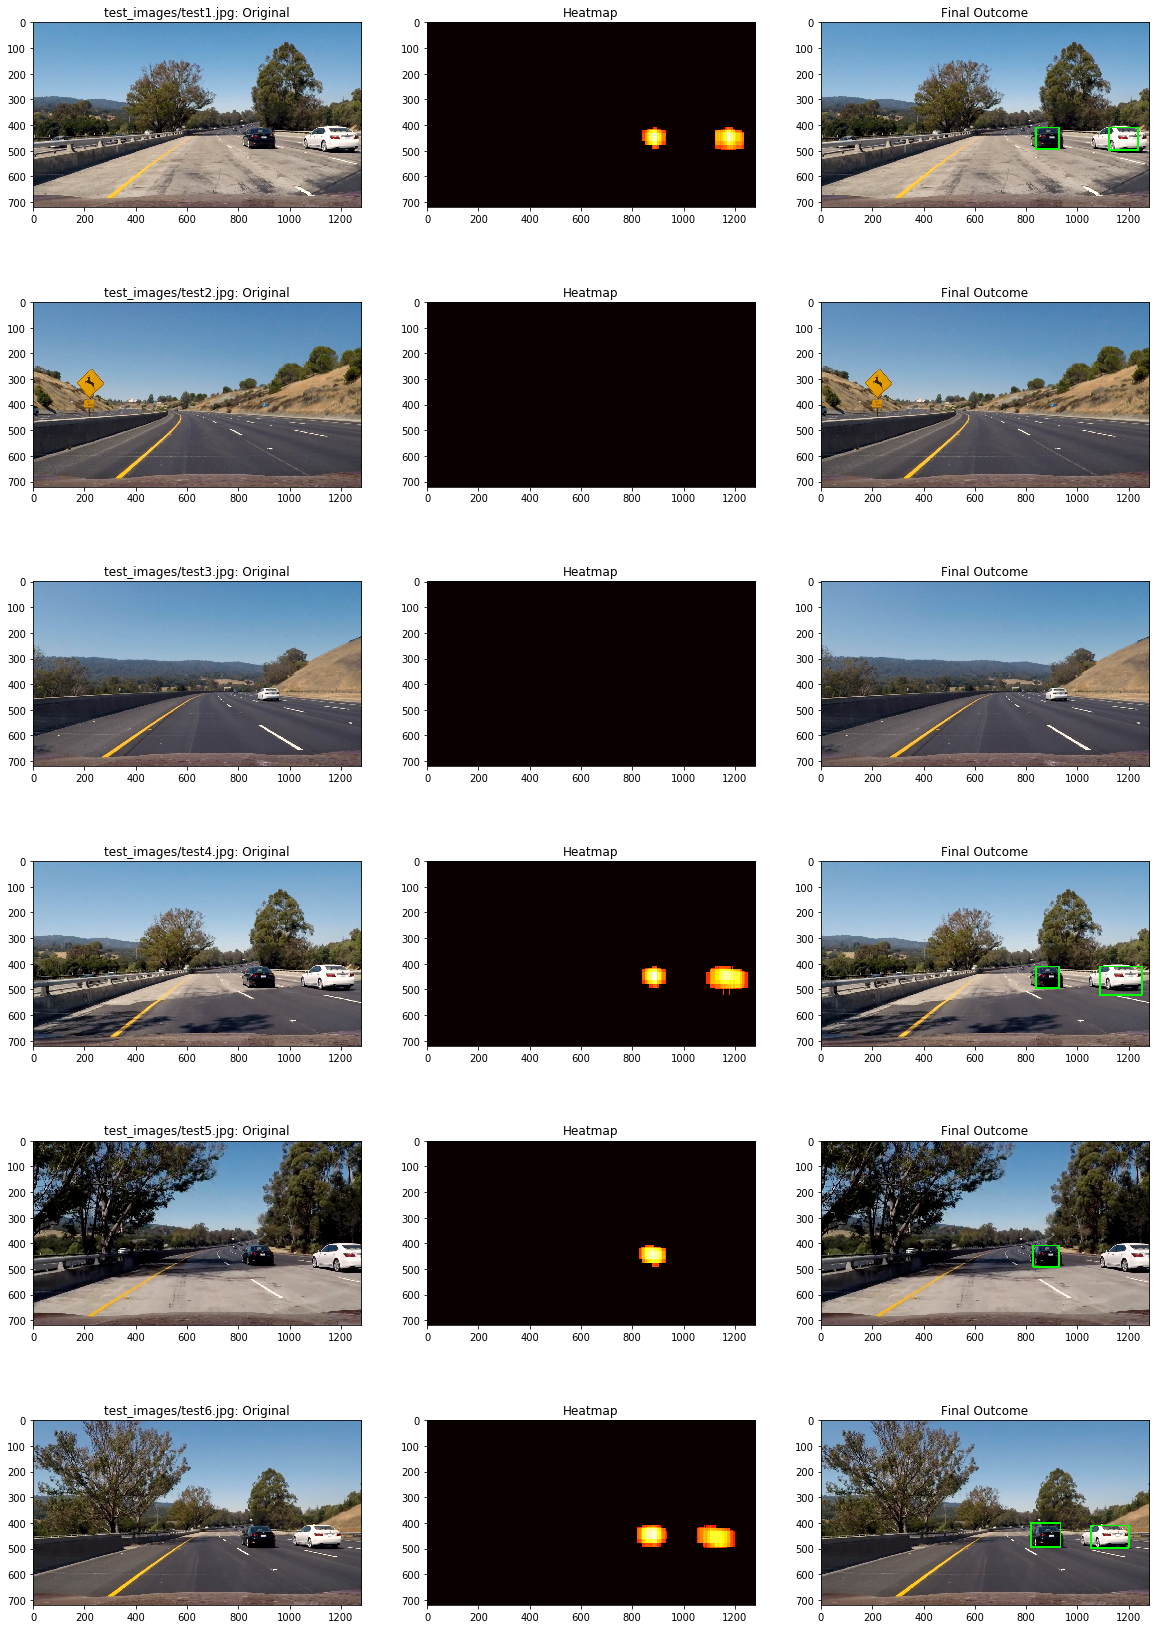

In [17]:
threshold=10

fig = plt.figure(figsize = (20, 30))

for i in range(len(test_images)):
    test_image = test_images[i]
    image = mpimg.imread(test_image)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    hot_windows = find_cars(image)
    heatmap = draw_heatmap(image, hot_windows, threshold=threshold)
    labels = draw_labels(draw_image, heatmap)

    ax1 = fig.add_subplot(6,3,(i*3)+1)
    ax1.set_title(test_image + ': Original')
    ax1.imshow(image)
    ax2 = fig.add_subplot(6,3,(i*3)+2)
    ax2.set_title('Heatmap')
    ax2.imshow(heatmap, cmap='hot')
    ax3 = fig.add_subplot(6,3,(i*3)+3)
    ax3.set_title('Final Outcome')
    ax3.imshow(labels)

## Video

### Import Packages

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def detect_cars(image):
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    hot_windows = find_cars(image)
    heatmap = draw_heatmap(image, hot_windows, threshold=threshold)
    labels = draw_labels(draw_image, heatmap)
    return labels

### Test Video

In [20]:
threshold=10

test_video_output = 'test_video_output.mp4'
test_video_input = VideoFileClip('test_video.mp4')
processed_test_video = test_video_input.fl_image(detect_cars)
%time processed_test_video.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [03:00<00:04,  4.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 2min 59s, sys: 722 ms, total: 3min
Wall time: 3min 1s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_output))

### Project Video

In [22]:
threshold=10

video_output = 'project_video_out.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(detect_cars)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [3:50:30<00:04,  4.49s/it]     


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 36min 18s, sys: 17.8 s, total: 1h 36min 36s
Wall time: 3h 50min 30s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))